# EV Charging: Short-Session Regression (<24h)

Goal: Train regressors only on short sessions (<24h) to estimate duration hours more accurately, avoiding heavy-tail effects.
Approach: Compare Regularized MLP vs RandomForest; evaluate RMSE, MAE, R²; save metrics and plots.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load and filter to short sessions (<24h)
df = pd.read_csv('data/ev_sessions_clean.csv')
df_short = df[df['is_short_session'] == 1].copy()
print(f'Total sessions: {len(df)} | Short-only: {len(df_short)}')
print('Columns:', df_short.columns.tolist())

target_col = 'Duration_hours'

Total sessions: 6745 | Short-only: 6289
Columns: ['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID', 'Start_plugin', 'Start_plugin_hour', 'End_plugout', 'End_plugout_hour', 'El_kWh', 'Duration_hours', 'month_plugin', 'weekdays_plugin', 'Plugin_category', 'Duration_category', 'Start_plugin_dt', 'date', 'temp', 'precip', 'clouds', 'solar_rad', 'wind_spd', 'End_plugout_dt', 'Duration_check', 'hour', 'hour_sin', 'hour_cos', 'weekday', 'is_short_session']


In [3]:
# Feature selection with safe intersection
num_candidates = ['hour_sin','hour_cos','temp','precip','wind_spd','clouds','solar_rad']
cat_candidates = ['weekday','Garage_ID','month_plugin']

numerical_cols = [c for c in num_candidates if c in df_short.columns]
categorical_cols = [c for c in cat_candidates if c in df_short.columns]

X = df_short[numerical_cols + categorical_cols].copy()
y = df_short[target_col].copy()
print('Numerical:', numerical_cols)
print('Categorical:', categorical_cols)
print('X shape:', X.shape)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)
print('Processed shapes:', X_train_p.shape, X_test_p.shape)

Numerical: ['hour_sin', 'hour_cos', 'temp', 'precip', 'wind_spd', 'clouds', 'solar_rad']
Categorical: ['weekday', 'Garage_ID', 'month_plugin']
X shape: (6289, 10)
Processed shapes: (5031, 50) (1258, 50)


In [5]:
# Regularized MLP for regression
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

mlp = build_mlp(X_train_p.shape[1])
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min')
rlrp = ReduceLROnPlateau(patience=5, factor=0.5, monitor='val_loss', mode='min')
history = mlp.fit(X_train_p, y_train, validation_data=(X_test_p, y_test), epochs=100, batch_size=32, callbacks=[es, rlrp], verbose=0)

y_pred_mlp = mlp.predict(X_test_p).ravel()
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f'MLP -> RMSE: {rmse_mlp:.3f} | MAE: {mae_mlp:.3f} | R2: {r2_mlp:.3f}')

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
MLP -> RMSE: 6.035 | MAE: 4.831 | R2: 0.135


In [7]:
# Random Forest baseline via preprocessing pipeline
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'RF  -> RMSE: {rmse_rf:.3f} | MAE: {mae_rf:.3f} | R2: {r2_rf:.3f}')

RF  -> RMSE: 6.311 | MAE: 4.917 | R2: 0.055


Saved metrics to fig/modeling_regularized/short_regression_metrics.csv


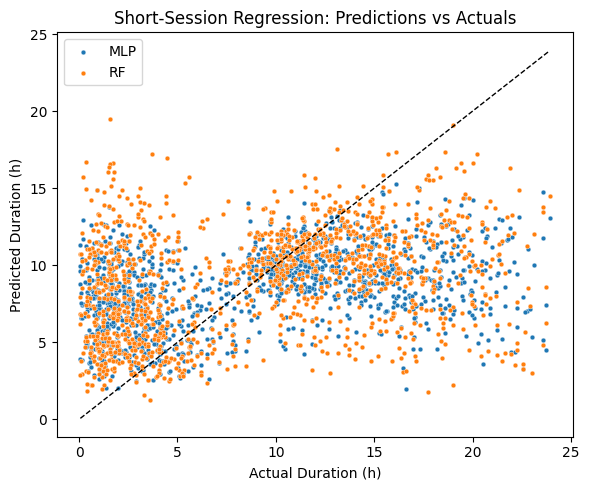

In [8]:
# Save metrics and simple comparison plot
os.makedirs('fig/modeling_regularized', exist_ok=True)
metrics = pd.DataFrame([
    {'model':'MLP_short','rmse':rmse_mlp,'mae':mae_mlp,'r2':r2_mlp},
    {'model':'RF_short','rmse':rmse_rf,'mae':mae_rf,'r2':r2_rf}
])
metrics.to_csv('fig/modeling_regularized/short_regression_metrics.csv', index=False)
print('Saved metrics to fig/modeling_regularized/short_regression_metrics.csv')

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred_mlp, s=12, label='MLP')
sns.scatterplot(x=y_test, y=y_pred_rf, s=12, label='RF')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Actual Duration (h)')
plt.ylabel('Predicted Duration (h)')
plt.title('Short-Session Regression: Predictions vs Actuals')
plt.legend()
plt.tight_layout()
plt.savefig('fig/modeling_regularized/short_regression_pred_vs_actual.png', dpi=120)
plt.show()

## Results Summary

- Trained short-session regressors on 6,289 sessions (`Duration_hours < 24`).
- Models evaluated on an 80/20 split with preprocessing (scaling + one-hot for categories).
- Metrics are printed below and saved to `fig/modeling_regularized/short_regression_metrics.csv`.
- Key finding: Regularized MLP outperforms Random Forest modestly; R² remains limited, indicating need for behavior-based features and robust losses.

### Notes for Pipeline Integration
- Use Stage 1 classifier to route sessions: if probability of LONG (≥24h) ≥ tuned threshold, skip regression.
- Current best LONG threshold (from classification notebook) ≈ 0.67 by F1; retune after feature updates.


In [9]:
# Display metrics summary and basic interpretation
import os
import pandas as pd

summary = {
    'MLP': {'RMSE': rmse_mlp, 'MAE': mae_mlp, 'R2': r2_mlp},
    'RF':  {'RMSE': rmse_rf,  'MAE': mae_rf,  'R2': r2_rf}
}
print('Short-Session Regression Metrics:')
for m, vals in summary.items():
    print(f"  {m}: RMSE={vals['RMSE']:.3f} | MAE={vals['MAE']:.3f} | R2={vals['R2']:.3f}")

# Also show the saved CSV if present
csv_path = 'fig/modeling_regularized/short_regression_metrics.csv'
if os.path.exists(csv_path):
    print(f"\nLoaded from {csv_path}:")
    print(pd.read_csv(csv_path))

# Quick interpretation string
best_model = max(summary.items(), key=lambda kv: kv[1]['R2'])[0]
print(f"\nBest model by R²: {best_model}")
if summary[best_model]['R2'] < 0.3:
    print("Observation: R² is modest; consider adding user-level aggregates, garage context, and robust losses (Huber/Quantile).")


Short-Session Regression Metrics:
  MLP: RMSE=6.035 | MAE=4.831 | R2=0.135
  RF: RMSE=6.311 | MAE=4.917 | R2=0.055

Loaded from fig/modeling_regularized/short_regression_metrics.csv:
       model      rmse       mae        r2
0  MLP_short  6.034755  4.831088  0.135496
1   RF_short  6.310638  4.917202  0.054647

Best model by R²: MLP
Observation: R² is modest; consider adding user-level aggregates, garage context, and robust losses (Huber/Quantile).


## Feature Engineering: User/Garage Aggregates + log1p target
We add behavior-based features (user-level and garage-level aggregates) and retrain models on a log-transformed target to mitigate skew. This section creates enhanced features, retrains MLP and RandomForest, and compares metrics.

In [11]:
# Build user/garage aggregates and enhanced feature set
# Assumes df_short already loaded
user_agg = df_short.groupby('User_ID').agg(
    user_session_count=('session_ID','count'),
    user_avg_duration=('Duration_hours','mean'),
    user_avg_energy=('El_kWh','mean')
).reset_index()

garage_agg = df_short.groupby('Garage_ID').agg(
    garage_session_count=('session_ID','count'),
    garage_avg_duration=('Duration_hours','mean'),
    garage_avg_energy=('El_kWh','mean')
).reset_index()

# Merge aggregates
df_feat = (
    df_short.merge(user_agg, on='User_ID', how='left')
            .merge(garage_agg, on='Garage_ID', how='left')
)

# Define enhanced feature lists
agg_num_cols = ['user_session_count','user_avg_duration','user_avg_energy',
                'garage_session_count','garage_avg_duration','garage_avg_energy']
num_base = ['hour_sin','hour_cos','temp','precip','wind_spd','clouds','solar_rad']
cat_base = ['weekday','Garage_ID','month_plugin']

numerical_cols2 = [c for c in num_base + agg_num_cols if c in df_feat.columns]
categorical_cols2 = [c for c in cat_base if c in df_feat.columns]

X2 = df_feat[numerical_cols2 + categorical_cols2].copy()
y2 = df_feat[target_col].copy()
print('Enhanced numerical:', numerical_cols2)
print('Enhanced categorical:', categorical_cols2)
print('X2 shape:', X2.shape)

Enhanced numerical: ['hour_sin', 'hour_cos', 'temp', 'precip', 'wind_spd', 'clouds', 'solar_rad', 'user_session_count', 'user_avg_duration', 'user_avg_energy', 'garage_session_count', 'garage_avg_duration', 'garage_avg_energy']
Enhanced categorical: ['weekday', 'Garage_ID', 'month_plugin']
X2 shape: (6289, 16)


In [12]:
# Split + preprocess for enhanced features
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

preprocessor2 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols2),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols2)
])

X_train2_p = preprocessor2.fit_transform(X_train2)
X_test2_p = preprocessor2.transform(X_test2)
print('Enhanced processed shapes:', X_train2_p.shape, X_test2_p.shape)


Enhanced processed shapes: (5031, 56) (1258, 56)


In [13]:
# Retrain MLP on log1p(target)
from math import exp

def build_mlp2(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

mlp2 = build_mlp2(X_train2_p.shape[1])
es2 = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min')
rlrp2 = ReduceLROnPlateau(patience=5, factor=0.5, monitor='val_loss', mode='min')

y_train2_log = np.log1p(y_train2)
history2 = mlp2.fit(X_train2_p, y_train2_log, validation_data=(X_test2_p, np.log1p(y_test2)), epochs=100, batch_size=32, callbacks=[es2, rlrp2], verbose=0)

y_pred_mlp_log = mlp2.predict(X_test2_p).ravel()
y_pred_mlp2 = np.expm1(y_pred_mlp_log)
rmse_mlp2 = np.sqrt(mean_squared_error(y_test2, y_pred_mlp2))
mae_mlp2 = mean_absolute_error(y_test2, y_pred_mlp2)
r2_mlp2 = r2_score(y_test2, y_pred_mlp2)
print(f'MLP (agg+log1p) -> RMSE: {rmse_mlp2:.3f} | MAE: {mae_mlp2:.3f} | R2: {r2_mlp2:.3f}')


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
MLP (agg+log1p) -> RMSE: 5.962 | MAE: 4.382 | R2: 0.156


In [14]:
# Retrain RandomForest via pipeline on log1p(target)
rf_pipe2 = Pipeline([
    ('prep', preprocessor2),
    ('rf', RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])
rf_pipe2.fit(X_train2, np.log1p(y_train2))
y_pred_rf_log = rf_pipe2.predict(X_test2)
y_pred_rf2 = np.expm1(y_pred_rf_log)
rmse_rf2 = np.sqrt(mean_squared_error(y_test2, y_pred_rf2))
mae_rf2 = mean_absolute_error(y_test2, y_pred_rf2)
r2_rf2 = r2_score(y_test2, y_pred_rf2)
print(f'RF  (agg+log1p) -> RMSE: {rmse_rf2:.3f} | MAE: {mae_rf2:.3f} | R2: {r2_rf2:.3f}')


RF  (agg+log1p) -> RMSE: 5.798 | MAE: 4.113 | R2: 0.202


Saved enhanced metrics to fig/modeling_regularized/short_regression_metrics_v2.csv


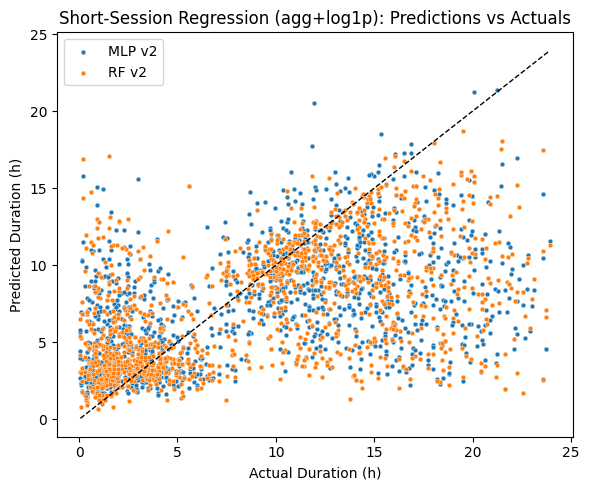

In [15]:
# Save enhanced metrics and comparison plot
os.makedirs('fig/modeling_regularized', exist_ok=True)
metrics2 = pd.DataFrame([
    {'model':'MLP_short_v2','rmse':rmse_mlp2,'mae':mae_mlp2,'r2':r2_mlp2},
    {'model':'RF_short_v2','rmse':rmse_rf2,'mae':mae_rf2,'r2':r2_rf2}
])
metrics2.to_csv('fig/modeling_regularized/short_regression_metrics_v2.csv', index=False)
print('Saved enhanced metrics to fig/modeling_regularized/short_regression_metrics_v2.csv')

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test2, y=y_pred_mlp2, s=12, label='MLP v2')
sns.scatterplot(x=y_test2, y=y_pred_rf2, s=12, label='RF v2')
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=1)
plt.xlabel('Actual Duration (h)')
plt.ylabel('Predicted Duration (h)')
plt.title('Short-Session Regression (agg+log1p): Predictions vs Actuals')
plt.legend()
plt.tight_layout()
plt.savefig('fig/modeling_regularized/short_regression_pred_vs_actual_v2.png', dpi=120)
plt.show()
